# Deep Learning course 2022-2023
## Project: Video Prediction on Moving MNIST
### Project Contributors
* Mattia Castelmare, 1815675
* Andrea Giuseppe Di Francesco, 1836928
* Enrico Fazzi, 2003876

#### Installation cells

In [ ]:
# !git clone https://github.com/tychovdo/MovingMNIST.git
# !wget http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
# !pip3 install torchvision
# !pip3 install matplotlib
# !pip install wandb
# !pip install pytorch-lightning==1.5.10
# !pip install pytorch-msssim

### Importing Libraries

In [3]:
### wandb codes ###
import wandb
#####################

import torch
import os
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning import Trainer
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from MovingMNIST.MovingMNIST import *

# from pytorch_msssim import ssim, SSIM
rc('animation', html='jshtml')


## Useful Functions

In [4]:
def show_video(tensor):
    ''' This function display a video, given a torch tensor (source: https://stackoverflow.com/questions/67261108/how-to-display-a-video-in-colab-using-a-pytorch-tensor-of-rgb-image-arrays)
        INPUT: tensor (Frames x Channels x Height x Width) 
        OUTPUT: Display an animation '''

    fig, ax = plt.subplots()

    imgs = tensor
    imgs = imgs.permute(0, 2, 3, 1)  # Permuting to (Bx)HxWxC format
    frames = [[ax.imshow(imgs[i], cmap='gray')] for i in range(len(imgs))]

    ani = animation.ArtistAnimation(fig, frames)
    return ani


def collate(batch):
    ''' This function is used within the Dataloader pytorch utility. 
        INPUT: batch: List of tuples of tensor, each tuple contains the input video and the target video, 
        OUTPUT: A tuple (input, gt), s.t. both of them has dimension (B x T x C x H x W)'''

    list_tuples = list(map(lambda x: (torch.reshape(x[0], (1, x[0].shape[0], 1, x[0].shape[1], x[0].shape[2])), torch.reshape(
        x[1], (1, x[1].shape[0], 1, x[1].shape[1], x[1].shape[2]))), batch))

    input = list_tuples[0][0]
    gt = list_tuples[0][1]

    for i in range(1, len(list_tuples)):
        input = torch.cat((input, list_tuples[i][0]), dim=0)
        gt = torch.cat((gt, list_tuples[i][1]), dim=0)
        

    return ((input/255).type(torch.FloatTensor), (gt/255).type(torch.FloatTensor))


def save_model(model, loss, path):
  # This function is a customized in order to save a pytorch model.
    checkpoint = {'model_state': model.state_dict(),
                  'loss': loss}
    torch.save(checkpoint, path)


def load_model(path, model):
  # This function loads a pytorch model from a path.
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state'])

    return checkpoint


def stride_generator(N, reverse=False):
    ''' This function is desired to know what is the list of stride values to use when defining an E-D architecture, it was taken by https://github.com/gaozhangyang/SimVP-Simpler-yet-Better-Video-Prediction. '''
    strides = [1, 2]*10
    if reverse:
        return list(reversed(strides[:N]))
    else:
        return strides[:N]


def kronecker_product(dyn, static):
    """ This function is a fast implementation of the kronocker product mentioned in the paper https://arxiv.org/pdf/2206.12126.pdf.
        The original implementation, from which we took inspiration is available at https://gist.github.com/yulkang/4a597bcc5e9ccf8c7291f8ecb776382d.
        INPUTs:
            -dyn: results of the dynamical attention module: (B, T*C, 1, 1),
            -static: results of the static attention module: (B, T*C, 32, 32).
        OUTPUTs:
            - res: Kronocker product result.
    """
    siz1 = torch.Size(torch.tensor(
        dyn.shape[-2:]) * torch.tensor(static.shape[-2:]))
    res = dyn.unsqueeze(-1).unsqueeze(-3) * static.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    return res.reshape(siz0 + siz1)


### Useful variables 

In [5]:
shuffle_train = True
shuffle_test = False
download = True

### wandb codes ###
wb = True
project_name = "VP_on_MMNIST"
if wb:
    wandb.login()
###################

SEED = 290200
pl.seed_everything(SEED)

root = './data'
if not os.path.exists(root):
    os.mkdir(root)

test_data = np.load('mnist_test_seq.npy')


wandb: Currently logged in as: difra00 (deepl_wizards). Use `wandb login --relogin` to force relogin
Global seed set to 290200


### Pytorch lightning DataModule:
* Set the MMNIST Dataset object and Dataloader 

In [6]:
class TestDataset(Dataset):

    def __init__(self, test_data):
        self.test_data = test_data
        self.test_data = self.process_image()
    def process_image(self):
        self.test_data = torch.tensor(self.test_data)
        self.input =  self.test_data[:10].permute(1, 0, 2, 3)
        self.input_ = self.input.reshape(self.input.shape[0], self.input.shape[1], 1, self.input.shape[2], self.input.shape[3])
        self.gt =  self.test_data[10:].permute(1, 0, 2, 3)
  
        self.gt_ =  self.gt.reshape(self.gt.shape[0], self.gt.shape[1], 1, self.gt.shape[2], self.gt.shape[3])
    
    def __len__(self):
        return self.input_.shape[0]
    def __getitem__(self, idx):
        return (self.input_[idx]/255).type(torch.FloatTensor), (self.gt_[idx]/255).type(torch.FloatTensor) 

class pl_Dataset(pl.LightningDataModule):

    def __init__(self, batch_size):

        self.bs = batch_size

    def setup(self, stage=None):
        if stage == 'fit':
            self.train_set = MovingMNIST(root=root,
                                         train=True,
                                         download=download)
        elif stage == 'test':
            # self.test_set = MovingMNIST(root=root,
            #                             train=False,
            #                             download=download)
            self.test_set = TestDataset(test_data)

    def train_dataloader(self, *args, **kwargs):

        train_loader = torch.utils.data.DataLoader(
            dataset=self.train_set,
            batch_size=self.bs,
            shuffle=shuffle_train,
            collate_fn=collate)

        return train_loader

    def val_dataloader(self, *args, **kwargs):

        # test_loader = torch.utils.data.DataLoader(
        #     dataset=self.test_set,
        #     batch_size=self.bs,
        #     shuffle=shuffle_test,
        #     collate_fn=collate)

        test_loader = DataLoader(self.test_set, shuffle = shuffle_test, batch_size = self.bs)

        return test_loader


### Hyperparameters

In [7]:
batch_size = 16
lr = 1e-2
wd = 5e-2
epochs = 200
dataset_length = 10000
tau = 1e-1 # KL Divergency parameter


### Vanilla hyperparameters ###

hyperparametersS = {'lr': lr,
                    'wd': wd,
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'CNN': {'input': 1,
                            'hidden_S': 64,  # Output channels in Encoder / Input channel in Decoder
                            'output_T': 512,  # Output channels in Inception, Hidden C. == Output channels // 2
                            'ksize': 3,
                            'Ns': 4,
                            'Nt': 3}
                    }

hyperparametersT = {'lr': lr,
                    'wd': wd,
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'CNN': {'input': 1,
                            'hidden_S': 64,
                            'ksize': 3
                            },
                    'n_layers': 4
                    }


data = pl_Dataset(batch_size)

data.setup(stage='fit')
data.setup(stage='test')


# Models

### Our VanillaED (Enry and Matty)
* Implementation of a Vanilla Encoder Decoder architecture with a skip connection

In [8]:
# Some of the following functions are inspired by https://github.com/gaozhangyang/SimVP-Simpler-yet-Better-Video-Prediction.

class VConvBlock(nn.Module):

    def __init__(self, inputC, outputC, stride=None, padding='same', transpose=False, kernel=hyperparametersT['CNN']['ksize']):
        super(VConvBlock, self).__init__()

        if not transpose:
           self.conv = nn.Conv2d(
                    inputC, outputC, kernel_size=kernel, padding=padding, stride=stride)
        else:
            self.conv = nn.ConvTranspose2d(
                inputC, outputC, kernel, stride=stride, padding=1, output_padding=stride // 2)

        self.layernorm = nn.GroupNorm(2, outputC)
        self.activation = nn.ReLU(inplace = True)

    def forward(self, x):

        x = self.conv(x)
        
        x = self.layernorm(x)

        x = self.activation(x)


        return x


class VEncoder(nn.Module):

    def __init__(self, n_layers):
        super(VEncoder, self).__init__()
        strides = stride_generator(n_layers)
        layers = [VConvBlock(hyperparametersS['CNN']['input'], hyperparametersS['CNN']
                            ['hidden_S'], stride=strides[0], padding=1)]

        for layer in range(1, n_layers):
            stride = strides[layer]
            layers.append(VConvBlock(
                hyperparametersT['CNN']['hidden_S'], hyperparametersT['CNN']['hidden_S'], stride=stride, padding=1))

        self.enc = nn.Sequential(*layers)

    def forward(self, x):

        B, T, C, H, W = x.shape

        x = x.reshape((B*T, C, H, W))

        skip = self.enc[0](x)
        x = self.enc(x)


        return x, skip



class VDecoder(nn.Module):

    def __init__(self, n_layers):
        super(VDecoder, self).__init__()
        strides = stride_generator(n_layers, reverse=True)
        layers = []
        for layer in range(n_layers-1):
            stride = strides[layer]
            layers.append(VConvBlock(hyperparametersT['CNN']['hidden_S'], hyperparametersT['CNN']
                          ['hidden_S'], transpose=True, stride=stride, padding=1))

        layers.append(VConvBlock(2*hyperparametersT['CNN']['hidden_S'], hyperparametersT['CNN']
                      ['hidden_S'], transpose=True, stride=strides[-1], padding=1))

        self.proj = nn.Conv2d(
            hyperparametersT['CNN']['hidden_S'], hyperparametersS['CNN']['input'], 1)

        self.dec = nn.Sequential(*layers)

    def forward(self, x, skip):

        for l_idx in range(len(self.dec)-1):
            x = self.dec[l_idx](x)

        x = self.dec[-1](torch.cat((x, skip), dim=1))
        x = self.proj(x)

        return x
class VEncoderDecoder(nn.Module):
    def __init__(self):
        super(VEncoderDecoder, self).__init__()


        self.encoder = VEncoder(hyperparametersS['CNN']['Ns'])
        self.decoder = VDecoder(hyperparametersS['CNN']['Ns'])


    def forward(self, input):
        B, T, C, H, W = input.shape
        output, skip = self.encoder(input)


        output = self.decoder(output, skip)
        
        output = output.reshape((B, T, C, H, W))

        return output

#### SimVP
* Implementation of the SimVP architecture, the details are available at https://arxiv.org/pdf/2206.05099.pdf,
* Encoder (CNN) +  Translator (Inception) + Decoder (CNN) 
* The implementation details were taken by the original implementation https://github.com/gaozhangyang/SimVP-Simpler-yet-Better-Video-Prediction , since some of them were neglected in the paper.

In [9]:
# Some of the following functions are inspired by https://github.com/gaozhangyang/SimVP-Simpler-yet-Better-Video-Prediction.

class ConvBlock(nn.Module):

    def __init__(self, inputC, outputC, stride=None, padding='same', transpose=False, groups=8, kernel=hyperparametersS['CNN']['ksize'], incep = False):
        super(ConvBlock, self).__init__()
        if inputC % groups != 0:
            groups = 1


        if not transpose:
            if incep:
                self.conv = nn.Conv2d(
                    inputC, outputC, kernel_size=kernel, padding=padding, stride=stride, groups = groups)
            else:
                self.conv = nn.Conv2d(
                    inputC, outputC, kernel_size=kernel, padding=padding, stride=stride)
        else:
            self.conv = nn.ConvTranspose2d(
                inputC, outputC, kernel, stride=stride, padding=1, output_padding=stride // 2)

        self.layernorm = nn.GroupNorm(groups, outputC)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):

        x = self.leaky(self.layernorm(self.conv(x)))

        return x


class EncoderSimVP(nn.Module):

    def __init__(self, n_layers):
        super(EncoderSimVP, self).__init__()
        strides = stride_generator(n_layers)
        layers = [ConvBlock(hyperparametersS['CNN']['input'], hyperparametersS['CNN']
                            ['hidden_S'], groups=2, stride=strides[0], padding=1)]

        for layer in range(1, n_layers):
            stride = strides[layer]
            layers.append(ConvBlock(
                hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']['hidden_S'], groups=2, stride=stride, padding=1))

        self.enc = nn.Sequential(*layers)

    def forward(self, x):

        B, T, C, H, W = x.shape

        x = x.reshape((B*T, C, H, W))

        skip = self.enc[0](x)
        x = self.enc(x)

        # x = x.reshape((B, T, hyperparameters['CNN']['hidden_S'], H, W))

        return x, skip



class DecoderSimVP(nn.Module):

    def __init__(self, n_layers):
        super(DecoderSimVP, self).__init__()
        strides = stride_generator(n_layers, reverse=True)
        layers = []
        for layer in range(n_layers-1):
            stride = strides[layer]
            layers.append(ConvBlock(hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']
                          ['hidden_S'], transpose=True, groups=2, stride=stride, padding=1))

        layers.append(ConvBlock(2*hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']
                      ['hidden_S'], transpose=True, groups=2, stride=strides[-1], padding=1))

        self.proj = nn.Conv2d(
            hyperparametersS['CNN']['hidden_S'], hyperparametersS['CNN']['input'], 1)

        self.dec = nn.Sequential(*layers)

    def forward(self, x, skip):

        for l_idx in range(len(self.dec)-1):
            x = self.dec[l_idx](x)

        x = self.dec[-1](torch.cat((x, skip), dim=1))
        x = self.proj(x)

        return x



class InceptionModule(nn.Module):

    def __init__(self, inputC, outputC, kernel_list=[3, 5, 7, 11], groups=8):
        super(InceptionModule, self).__init__()

        hiddenC = outputC // 2

        self.Conv = nn.Conv2d(
            inputC, hiddenC, kernel_size=1, stride=1, padding=0)

        layers = []

        for kernel in kernel_list:
            layers.append(ConvBlock(hiddenC, outputC, groups=groups,
                          stride=1, padding=kernel // 2, kernel=kernel, incep = True))

        self.ConvParallel = nn.Sequential(*layers)

    def forward(self, input):

        x = self.Conv(input)

        output = 0

        for conv in self.ConvParallel:

            output += conv(x)

        return output



    
class Translator(nn.Module):

    def __init__(self, n_layers, inputC):
        super(Translator, self).__init__()

        self.n_layers = n_layers
        enc_layers = [InceptionModule(
            inputC, hyperparametersS['CNN']['output_T'])]

        for inc_layer in range(1, n_layers-1):
            enc_layers.append(InceptionModule(
                hyperparametersS['CNN']['output_T'], hyperparametersS['CNN']['output_T']))

        enc_layers.append(InceptionModule(
            hyperparametersS['CNN']['output_T'], hyperparametersS['CNN']['output_T']))

        self.encoder = nn.Sequential(*enc_layers)

        dec_layers = [InceptionModule(
            hyperparametersS['CNN']['output_T'], hyperparametersS['CNN']['output_T'])]

        for inc_layers in range(1, n_layers-1):
            dec_layers.append(InceptionModule(
                2*hyperparametersS['CNN']['output_T'], hyperparametersS['CNN']['output_T']))
        dec_layers.append(InceptionModule(
            2*hyperparametersS['CNN']['output_T'], inputC))

        self.decoder = nn.Sequential(*dec_layers)

    def forward(self, input):
        B, T, C, H, W = input.shape
        input = input.reshape((B, T*C, H, W))

        enc_feat = []
        mid_feat = input

        for encoder_layer in self.encoder:
            mid_feat = encoder_layer(mid_feat)
            enc_feat.append(mid_feat)

        output = self.decoder[0](mid_feat)

        for l_idx in range(1, self.n_layers):

            input = torch.cat((output, enc_feat[-l_idx]), dim=1)
            output = self.decoder[l_idx](input)

        output = output.reshape((B, T, C, H, W))

        return output


class SimVP(nn.Module):
    def __init__(self):
        super(SimVP, self).__init__()

        self.encoder = EncoderSimVP(hyperparametersS['CNN']['Ns'])
        self.translator = Translator(
            hyperparametersS['CNN']['Nt'], 10*hyperparametersS['CNN']['hidden_S'])
        self.decoder = DecoderSimVP(hyperparametersS['CNN']['Ns'])

    def forward(self, input):
        B, T, C, H, W = input.shape

        output, skip = self.encoder(input)
        _, C_, H_, W_ = output.shape
        output = output.view(B, T, C_, H_, W_)

        output = self.translator(output)

        output = output.reshape((B*T, C_, H_, W_))

        Y = self.decoder(output, skip)

        Y = Y.reshape((B, T, C, H, W))

        return Y


### TAU Module
* Implementation of th Temporal Attention Unit architecture

In [10]:
''' Static attention parameters where slightly by inspired by the repository available at https://github.com/chengtan9907/SimVPv2.,
    Dynamic attention, and squeeze and excitation were partially inspired by https://blog.paperspace.com/channel-attention-squeeze-and-excitation-networks/, but the main implementation derives from the details in the original paper (https://arxiv.org/pdf/1709.01507.pdf) '''
class Static_attention(nn.Module):

    def __init__(self, dim, kernel_size):
        super(Static_attention, self).__init__()
      
        dilation = 3
        self.act = nn.Sigmoid() # if needed
        d_k = 2 * dilation - 1
        d_p = (d_k - 1) // 2
        dd_k = kernel_size // dilation + ((kernel_size // dilation) % 2 - 1)
        dd_p = (dilation * (dd_k - 1) // 2)

        self.conv0 = nn.Conv2d(dim, dim, d_k, padding=d_p, groups=dim)
        self.conv_spatial = nn.Conv2d(dim, dim, dd_k, stride=1, padding=dd_p, groups=dim, dilation=dilation)
        self.conv1 = nn.Conv2d(dim, dim, 1)

    def forward(self, x):

        x = self.conv1(self.conv_spatial(self.conv0(x)))

        return x


class Dynamic_attention(nn.Module):

    def __init__(self, dim, kernel_size):
        super(Dynamic_attention, self).__init__()
        reduction = 16
        self.reduction = max(dim // reduction, 4)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(dim, dim // self.reduction, bias=False), # reduction
            nn.ReLU(True),
            nn.Linear(dim // self.reduction, dim, bias=False), # expansion
            nn.Sigmoid()
        )
     
    def forward(self, x):
        B, _, _, _ = x.shape
        x = self.avg_pool(x)
        des_shape = x.shape
        
        x = x.view(B, -1)
        x = self.fc(x)
        
        x = x.reshape(des_shape)

        return x


class TAU(nn.Module):      # Large Kernel Attention
    def __init__(self, dim, kernel_size):
        super(TAU, self).__init__()
        self.static_net = Static_attention(dim, kernel_size)
        self.dynamic_net = Dynamic_attention(dim, kernel_size) 


    def forward(self, x):
        
        stat = self.static_net(x)

        dyn = self.dynamic_net(x)

        k_prod = kronecker_product(dyn, stat)

        out = k_prod * x

        return out

class TAUNet(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, n_layers = 4):
        super(TAUNet, self).__init__()

        # self.encoder = VEncoder(input_channels=input_channels, output_channels=output_channels,
        #                         kernel_size=kernel_size, n_layers=n_layers)
        # self.decoder = VDecoder(input_channels=output_channels, output_channels=input_channels, kernel_size=kernel_size,
        #                         n_layers=n_layers)
        self.encoder = VEncoder(n_layers)
        self.decoder = VDecoder(n_layers)

        input_shape = (10*output_channels, 32, 32)
        
        self.tau = TAU(input_shape[0], kernel_size=21)

        self.num_layers = n_layers

        self.final = nn.Conv2d(in_channels=2*output_channels, out_channels=input_channels, kernel_size=kernel_size, padding = 'same')

    def forward(self, input):
        B, T, C, H, W = input.shape
        # input = input.reshape((B*T, C, H, W))
        output, skip = self.encoder(input)

        BT, C_, H_, W_ = output.shape

        output = output.reshape((B, T, C_, H_, W_))
        output = output.reshape((B, T*C_, H_, W_))

        output = self.tau(output)


        output = output.reshape((B, T, C_, H_, W_))
        output = output.reshape((B*T, C_, H_, W_))

        output = self.decoder(output, skip)
        
        # output = torch.cat((skip, output), dim = 1)
        # output = self.final(output)

        output = output.reshape((B, T, C, H, W))
        
        

        return output


In [20]:
import math
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1)  # 1x1
        self.dwconv = DWConv(hidden_features)                  # CFF: Convlutional feed-forward network
        self.act = act_layer()                                 # GELU
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1) # 1x1
        self.drop = nn.Dropout(drop)
    #     self.apply(self._init_weights)

    # def _init_weights(self, m):
    #     if isinstance(m, nn.Linear):
    #         trunc_normal_(m.weight, std=.02)
    #         if isinstance(m, nn.Linear) and m.bias is not None:
    #             nn.init.constant_(m.bias, 0)
    #     elif isinstance(m, nn.LayerNorm):
    #         nn.init.constant_(m.bias, 0)
    #         nn.init.constant_(m.weight, 1.0)
    #     elif isinstance(m, nn.Conv2d):
    #         fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
    #         fan_out //= m.groups
    #         m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
    #         if m.bias is not None:
    #             m.bias.data.zero_()

    def forward(self, x):

        x = self.fc1(x)


        x = self.dwconv(x)

        x = self.act(x)

        x = self.drop(x)

        x = self.fc2(x)

        x = self.drop(x)

        return x


class AttentionModule(nn.Module):      # Large Kernel Attention
    def __init__(self, dim, kernel_size, dilation=3):
        super().__init__()
        d_k = 2 * dilation - 1
        d_p = (d_k - 1) // 2
        dd_k = kernel_size // dilation + ((kernel_size // dilation) % 2 - 1)
        dd_p = (dilation * (dd_k - 1) // 2)

        self.conv0 = nn.Conv2d(dim, dim, d_k, padding=d_p, groups=dim)
        self.conv_spatial = nn.Conv2d(dim, dim, dd_k, stride=1, padding=dd_p, groups=dim, dilation=dilation)
        self.conv1 = nn.Conv2d(dim, 2*dim, 1)

        reduction = 16
        self.reduction = max(dim // reduction, 4)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(dim, dim // self.reduction, bias=False), # reduction
            nn.ReLU(True),
            nn.Linear(dim // self.reduction, dim, bias=False), # expansion
            nn.Sigmoid()
        )

        # GATE
        self.conv2_0 = nn.Conv2d(dim, dim, d_k, padding=d_p, groups=dim)
        self.conv2_spatial = nn.Conv2d(dim, dim, dd_k, stride=1, padding=dd_p, groups=dim, dilation=dilation)
        self.conv2_1 = nn.Conv2d(dim, dim, 1)

    def forward(self, x):
        u = x.clone()
        attn = self.conv0(x)           # depth-wise conv
        attn = self.conv_spatial(attn) # depth-wise dilation convolution
        
        f_g = self.conv1(attn)
        split_dim = f_g.shape[1] // 2
        f_x, g_x = torch.split(f_g, split_dim, dim=1)
        return torch.sigmoid(g_x) * f_x

class SpatialAttention(nn.Module):
    def __init__(self, d_model, kernel_size=21):
        super().__init__()

        self.proj_1 = nn.Conv2d(d_model, d_model, 1)         # 1x1 conv
        self.activation = nn.GELU()                          # GELU
        self.spatial_gating_unit = AttentionModule(d_model, kernel_size)
        self.proj_2 = nn.Conv2d(d_model, d_model, 1)         # 1x1 conv

    def forward(self, x):
        # shorcut = x.clone()
        x = self.proj_1(x)

        x = self.activation(x)

        x = self.spatial_gating_unit(x)

        # x = self.proj_2(x)

        # x = x + shorcut
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x):
        x = self.dwconv(x)
        return x

class GASubBlock(nn.Module):
    def __init__(self, dim, kernel_size=21, mlp_ratio=4., drop=0., drop_path=0.1, act_layer=nn.GELU):
        super().__init__()
        self.norm1 = nn.BatchNorm2d(dim)
        self.attn = SpatialAttention(dim, kernel_size)
        # self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        # self.norm2 = nn.BatchNorm2d(dim)
        # mlp_hidden_dim = int(dim * mlp_ratio)
        # self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        # layer_scale_init_value = 1e-2
        # self.layer_scale_1 = nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True)
        # self.layer_scale_2 = nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True)

    #     self.apply(self._init_weights)

    # def _init_weights(self, m):
    #     if isinstance(m, nn.Linear):
    #         trunc_normal_(m.weight, std=.02)
    #         if isinstance(m, nn.Linear) and m.bias is not None:
    #             nn.init.constant_(m.bias, 0)
    #     elif isinstance(m, nn.LayerNorm):
    #         nn.init.constant_(m.bias, 0)
    #         nn.init.constant_(m.weight, 1.0)
    #     elif isinstance(m, nn.Conv2d):
    #         fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
    #         fan_out //= m.groups
    #         m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
    #         if m.bias is not None:
    #             m.bias.data.zero_()

    def forward(self, x):
        x = self.attn(self.norm1(x)) #self.drop_path(self.layer_scale_1.unsqueeze(-1).unsqueeze(-1) * self.attn(self.norm1(x)))
        # x = x + self.drop_path(self.layer_scale_2.unsqueeze(-1).unsqueeze(-1) * self.mlp(self.norm2(x)))
        return x
    
def sampling_generator(N, reverse=False):
    samplings = [False, True] * (N // 2)
    if reverse: return list(reversed(samplings[:N]))
    else: return samplings[:N]


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation=1, upsampling=False, act_norm=False):
        super(BasicConv2d, self).__init__()
        self.act_norm = act_norm
        if upsampling is True:
            self.conv = nn.Sequential(*[
                nn.Conv2d(in_channels, out_channels*4, kernel_size=kernel_size,
                          stride=1, padding=padding, dilation=dilation),
                nn.PixelShuffle(2)
            ])
        else:
            self.conv = nn.Conv2d(
                in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation)

        self.norm = nn.GroupNorm(2, out_channels)
        self.act = nn.SiLU(True)

        # self.apply(self._init_weights)

    # def _init_weights(self, m):
    #     if isinstance(m, (nn.Conv2d)):
    #         trunc_normal_(m.weight, std=.02)
    #         nn.init.constant_(m.bias, 0)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.act(self.norm(y))
        return y


class ConvSC(nn.Module):
    def __init__(self, C_in, C_out, kernel_size=3, downsampling=False, upsampling=False, act_norm=True, is_3d=False):
        super(ConvSC, self).__init__()

        stride = 2 if downsampling is True else 1
        padding = (kernel_size - stride + 1) // 2

        self.conv = BasicConv2d(C_in, C_out, kernel_size=kernel_size, stride=stride, upsampling=upsampling,
                            padding=padding, act_norm=act_norm)

    def forward(self, x):
        y = self.conv(x)
        return y


class GroupConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding,groups,act_norm=False):
        super(GroupConv2d, self).__init__()
        self.act_norm=act_norm
        if in_channels%groups != 0:
            groups=1
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,groups=groups)
        self.norm = nn.GroupNorm(groups,out_channels)
        self.activate = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.activate(self.norm(y))
        return y

        
class gInception_ST(nn.Module):
    def __init__(self, C_in, C_hid, C_out, incep_ker = [3,5,7,11], groups = 8):        
        super(gInception_ST, self).__init__()
        self.conv1 = nn.Conv2d(C_in, C_hid, kernel_size=1, stride=1, padding=0)

        layers = []
        for ker in incep_ker:
            layers.append(GroupConv2d(C_hid, C_out, kernel_size=ker, stride=1, padding=ker//2, groups=groups, act_norm=True))
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        y = 0
        for layer in self.layers:
            y += layer(x)
        return y


class Encoder(nn.Module):
    def __init__(self, C_in, C_hid, N_S, spatio_kernel):
        samplings = sampling_generator(N_S)
        super(Encoder, self).__init__()
        self.enc = nn.Sequential(
            ConvSC(C_in, C_hid, spatio_kernel, downsampling=samplings[0]),
            *[ConvSC(C_hid, C_hid, spatio_kernel, downsampling=s) for s in samplings[1:]]
        )

    def forward(self, x):  # B*4, 3, 128, 128
        enc1 = self.enc[0](x)
        latent = enc1
        for i in range(1, len(self.enc)):
            latent = self.enc[i](latent)
        return latent, enc1


class Decoder(nn.Module):
    def __init__(self, C_hid, C_out, N_S, spatio_kernel):
        samplings = sampling_generator(N_S, reverse=True)
        super(Decoder, self).__init__()
        self.dec = nn.Sequential(
            *[ConvSC(C_hid, C_hid, spatio_kernel, upsampling=s) for s in samplings[:-1]],
            ConvSC(C_hid, C_hid, spatio_kernel, upsampling=samplings[-1])
        )
        self.readout = nn.Conv2d(C_hid, C_out, 1)

    def forward(self, hid, enc1=None):
        for i in range(0, len(self.dec)-1):
            hid = self.dec[i](hid)
        Y = self.dec[-1](hid + enc1)
        Y = self.readout(Y)
        return Y


class GABlock(nn.Module):
    def __init__(self, in_channels, out_channels, mlp_ratio=8., drop=0.0, drop_path=0.0):
        super(GABlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.block = GASubBlock(in_channels, kernel_size=21, mlp_ratio=mlp_ratio, drop=drop, drop_path=drop_path, act_layer=nn.GELU)

        if in_channels != out_channels:
            self.reduction = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
            
    def forward(self, x):
        z = self.block(x)
        return z if self.in_channels == self.out_channels else self.reduction(z)


class Mid_GANet(nn.Module):
    def __init__(self, channel_in, channel_hid, N2, mlp_ratio=4., drop=0.0, drop_path=0.1):
        super(Mid_GANet, self).__init__()

        self.N2 = N2
        enc_layers = [GABlock(channel_in, channel_hid, mlp_ratio=mlp_ratio, drop=drop, drop_path=drop_path)]
        for i in range(1, N2-1):
            enc_layers.append(GABlock(channel_hid, channel_hid, mlp_ratio=mlp_ratio, drop=drop, drop_path=drop_path))
        enc_layers.append(GABlock(channel_hid, channel_in, mlp_ratio=mlp_ratio, drop=drop, drop_path=drop_path))
        self.enc = nn.Sequential(*enc_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.reshape(B, T*C, H, W)
        z = x
        for i in range(self.N2):
            z = self.enc[i](z)

        y = z.reshape(B, T, C, H, W)
        return y


class Mid_IncepNet(nn.Module):
    def __init__(self, channel_in, channel_hid, N2, incep_ker=[3,5,7,11], groups=8, **kwargs):
        super(Mid_IncepNet, self).__init__()

        self.N2 = N2
        enc_layers = [gInception_ST(channel_in, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1,N2-1):
            enc_layers.append(gInception_ST(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        enc_layers.append(gInception_ST(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))


        dec_layers = [gInception_ST(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1,N2-1):
            dec_layers.append(gInception_ST(2*channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        dec_layers.append(gInception_ST(2*channel_hid, channel_hid//2, channel_in, incep_ker= incep_ker, groups=groups))


        self.enc = nn.Sequential(*enc_layers)
        self.dec = nn.Sequential(*dec_layers)

    def forward(self, x):
        B,T,C,H,W = x.shape
        x = x.reshape(B,T*C,H,W)
    
        # encoder
        skips = []
        z = x
        for i in range(self.N2):
            z = self.enc[i](z)
            if i < self.N2-1:
                skips.append(z)

        # decoder
        z = self.dec[0](z)
        for i in range(1,self.N2):
            z = self.dec[i](torch.cat([z, skips[-i]], dim=1) )

        y = z.reshape(B,T,C,H,W)
        return y


class SimVP_Model(nn.Module):
    def __init__(self, in_shape, hid_S=16, hid_T=256, N_S=4, N_T=4, model_type='',
        mlp_ratio=8., drop=0.0, drop_path=0.0, spatio_kernel_enc=3, spatio_kernel_dec=3, pre_seq_length=10, aft_seq_length=10, **kwargs):
        super(SimVP_Model, self).__init__()
        T, C, H, W = in_shape

        self.enc = Encoder(C, hid_S, N_S, spatio_kernel_enc)
        self.dec = Decoder(hid_S, C, N_S, spatio_kernel_dec)

        if model_type == 'IncepU':
            self.hid = Mid_IncepNet(T*hid_S, hid_T, N_T)
        else:
            self.hid = Mid_GANet(T*hid_S, hid_T, N_T, mlp_ratio=mlp_ratio, drop=drop, drop_path=drop_path)
        
    def forward(self, x_raw):
        B, T, C, H, W = x_raw.shape
        x = x_raw.view(B*T, C, H, W)

        embed, skip = self.enc(x)
        _, C_, H_, W_ = embed.shape
        z = embed.view(B, T, C_, H_, W_)

        hid = self.hid(z)
        hid = hid.reshape(B*T, C_, H_, W_)

        Y = self.dec(hid, skip)
        Y = Y.reshape(B, T, C, H, W)
            
        return Y

In [18]:
mod = SimVP_Model((10,1,64,64), hid_S = 64, hid_T = 512, N_S = 4, N_T = 8)
t = torch.randn((16, 10, 1, 64, 64))

In [19]:
out = mod(t)
print(out.shape)

torch.Size([16, 10, 1, 64, 64])


# LOSSES

In [21]:
class MSE_loss(nn.Module):
    ''' This class resembles the mean squared error so as defined in the evaluation for the video prediction task. '''

    def __init__(self):
        super(MSE_loss, self).__init__()
        self.loss = nn.MSELoss(reduction='sum')

    def forward(self, pred, true):
        B, T, C, H, W = pred.shape

        pred = pred.reshape((B*T, C, H, W))
        true = true.reshape((B*T, C, H, W))
        loss = []

        for i in range(pred.shape[0]):
            inter_loss = self.loss(pred[i], true[i])
            loss.append(inter_loss)

        tot_loss = sum(loss)/len(loss)

        return tot_loss


class plTrainingModule(pl.LightningModule):

    def __init__(self, model, model_conf, path=None, save=False, load=False):
        super(plTrainingModule, self).__init__()
        self.model = model
        self.mc = model_conf
        self.save = save
        self.load = load
        self.dest_path = path

        self.MSE = MSE_loss()
        if self.mc == 'tau':
            self.KL = nn.KLDivLoss()

        self.KL_list = []
        self.tot_loss_tr = []
        self.tot_loss = []
        self.mse_list = []
        self.save_loss = []

        if self.load:
            load_model(self.dest_path, self.model)

    def training_step(self, batch, batch_idx):

        ground_truth = batch[1]

        ### OUTPUT COMPUTATION ###

        prediction = self.model(batch[0])
        mse = self.MSE(prediction, ground_truth)

        loss = mse

        if self.mc == 'tau':
            KL_Loss = self.compute_KLloss(prediction, ground_truth)
 
            loss += KL_Loss

        self.tot_loss_tr.append(loss.item())

        return loss

    def validation_step(self, batch, batch_idx):

        ground_truth = batch[1]

        ### OUTPUT COMPUTATION ###

        prediction = self.model(batch[0])
        mse = self.MSE(prediction, ground_truth)

        loss = mse

        if self.mc == 'tau':
            KL_Loss = self.compute_KLloss(prediction, ground_truth)
            loss += KL_Loss
            self.KL_list.append(KL_Loss.item())

        self.tot_loss.append(loss.item())

        self.mse_list.append(mse.item())

        return loss

    def compute_KLloss(self, predicted, ground_truth):
        loss = []
        B, T, C, H, W = predicted.shape
        B, T, C, H, W = ground_truth.shape

        pred = predicted.reshape((B*T, C, H, W))
        ground = ground_truth.reshape((B*T, C, H, W))

        delta_pred = (pred[1:] - pred[:-1])/tau
        delta_gt = (ground[1:] - ground[:-1])/tau

        # 2 is the channel-related dimension
        soft_pred = F.softmax(delta_pred, dim=2)
        # 2 is the channel-related dimension
        soft_gt = F.softmax(delta_gt, dim=2)

        KL_Loss = self.KL(delta_pred, delta_gt)
        loss.append(KL_Loss)
        tot_loss = sum(loss)/len(loss)

        return KL_Loss

    def on_epoch_end(self):
        if len(self.tot_loss_tr) != 0:
            loss_train_mean = sum(self.tot_loss_tr)/len(self.tot_loss_tr)
            loss_mean = sum(self.tot_loss)/len(self.tot_loss)

            mse_mean = sum(self.mse_list)/len(self.mse_list)

            self.log(name='TOT. Loss on train', value=loss_train_mean,
                     on_epoch=True, prog_bar=True, logger=True)
            self.log(name='TOT. Loss on test', value=loss_mean,
                     on_epoch=True, prog_bar=True, logger=True)
            self.log(name='MSE loss on test', value=mse_mean,
                     on_epoch=True, prog_bar=True, logger=True)

            if self.mc == 'tau':
                KL_mean = sum(self.KL_list)/len(self.KL_list)
                self.log(name='KL loss on test', value=KL_mean,
                         on_epoch=True, prog_bar=True, logger=True)
                self.KL_list = []
            self.tot_loss_tr = []
            self.tot_loss = []
            self.mse_list = []
            self.save_loss.append(mse_mean)
            if self.save:

                save_model(self.model, self.save_loss, self.dest_path)

    def configure_optimizers(self):

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)#, weight_decay = wd)
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
        self.optimizer, max_lr=lr, total_steps = (dataset_length//batch_size)*epochs)
        return [self.optimizer], [self.scheduler]


In [22]:
num_gpu = 1 if torch.cuda.is_available() else 0


save = False
load = False


model_conf = 'simvp'

if model_conf == 'tau' or model_conf == 'random':
    hyperparameters = hyperparametersT
elif model_conf == 'simvp':
    hyperparameters = hyperparametersS

exp_name = 'no_weights_simvp2'+'_'+str(SEED)

path = 'tau_model_augdata.pt'


In [23]:
if model_conf == 'tau':
    model = TAUNet(hyperparameters['CNN']['input'], hyperparameters['CNN']
                   ['hidden_S'], hyperparameters['CNN']['ksize'], hyperparameters['n_layers'])
elif model_conf == 'random':
    model = VEncoderDecoder()
elif model_conf == 'simvp':
    model = SimVP_Model((10,1,64,64), hid_S = 64, hid_T = 512, N_S = 4, N_T = 8)#SimVP()


pl_training_MDL = plTrainingModule(
    model, model_conf, path, save=save, load=load)


### WANDB CODE ###
if wb:

    wandb_logger = WandbLogger(
        project=project_name, name=exp_name, config=hyperparameters, entity='deepl_wizards')
    trainer = pl.Trainer(
        max_epochs=hyperparameters['epochs'],  # maximum number of epochs.
        gpus=num_gpu,  # the number of gpus we have at our disposal.
        # , overfit_batches = 1
        default_root_dir="", logger=wandb_logger, callbacks=[TQDMProgressBar(refresh_rate=20)], deterministic = True
    )

else:
    trainer = pl.Trainer(
        max_epochs=hyperparameters['epochs'],  # maximum number of epochs.
        gpus=num_gpu,  # the number of gpus we have at our disposal.
        default_root_dir="", callbacks=[TQDMProgressBar(refresh_rate=20)], deterministic = True
    )


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [24]:
trainer.fit(model=pl_training_MDL, datamodule=data)
# WANDB code
wandb.finish()


/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | SimVP_Model | 13.2 M
1 | MSE   | MSE_loss    | 0     
--------------------------------------
13.2 M    Trainable params
0         Non-trainable params
13.2 M    Total params
52.673    Total estimated model params size (MB)
/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/peppe/Desktop/Università/Projects/Video_Prediction_on_Moving_MNIST/no_weights_simvp2_290200/version_None/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} ex

/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 290200
/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████▉| 1180/1188 [00:55<00:00, 21.10it/s, loss=130]

Epoch 32:  45%|████▌     | 540/1188 [00:43<00:51, 12.55it/s, loss=36, v_num=gjqe, TOT. Loss on train=36.60, TOT. Loss on test=41.70, MSE loss on test=41.70]   

--2023-02-08 18:56:08--  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819200096 (781M)
Saving to: ‘mnist_test_seq.npy’

mnist_test_seq.npy  100%[===================>] 781,25M  5,06MB/s    in 2m 3s   

2023-02-08 18:58:13 (6,33 MB/s) - ‘mnist_test_seq.npy’ saved [819200096/819200096]

--2023-02-08 18:58:13--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 188.114.96.7, 188.114.97.7, 2a06:98c1:3121::7, ...
Connecting to yann.lecun.com (yann.lecun.com)|188.114.96.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9,5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9,45M  8,39MB/s    in 1,1s    

2023-02-08 

In [87]:
test = np.load('mnist_test_seq.npy')

In [88]:
test.shape

(20, 10000, 64, 64)

In [160]:
loss = MSE_loss()
loss_list = []
c = 0
model.to('cuda')

for batch in data.train_dataloader():
    if c == 1:
        break
    input = batch[0].to('cuda')
    gt = batch[1].to('cuda')
    output = model(batch[0].to('cuda'))

    inter_loss = loss(output, input)
    loss_list.append(inter_loss)

    c += 1


In [ ]:
load_model('simvp_1000.pt', model)


In [163]:
save_model(model, [], 'simvp_cool.pt')

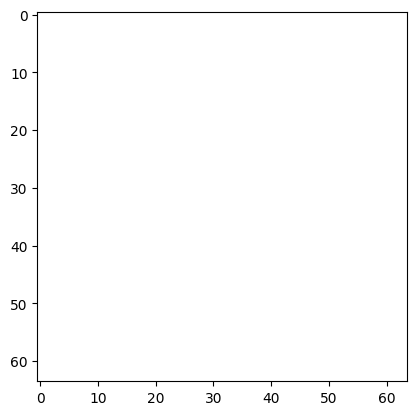

Epoch 12:  86%|████████▌ | 1020/1188 [01:55<00:19,  8.83it/s, loss=36.2, v_num=61h2, TOT. Loss on train=39.70, TOT. Loss on test=41.10, MSE loss on test=41.10]

Exception in thread SockSrvRdThr:
Traceback (most recent call last):
  File "/home/peppe/anaconda3/envs/my_env/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/wandb/sdk/service/server_sock.py", line 112, in run
    shandler(sreq)
  File "/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/wandb/sdk/service/server_sock.py", line 173, in server_record_publish
    iface = self._mux.get_stream(stream_id).interface
  File "/home/peppe/anaconda3/envs/my_env/lib/python3.10/site-packages/wandb/sdk/service/streams.py", line 199, in get_stream
    stream = self._streams[stream_id]
KeyError: '1cth61h2'


In [ ]:
show_video(gt[2].cpu())

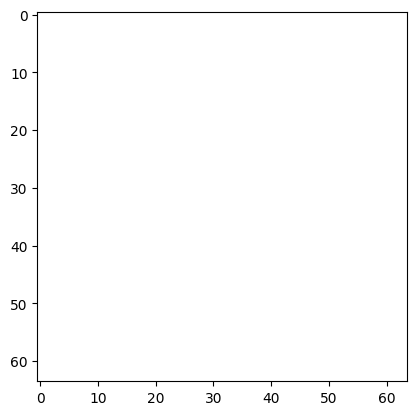

In [162]:
show_video(output[2].cpu().detach())

In [ ]:
show_video(batch[0][0].detach())


In [ ]:
torch.tensor()

In [111]:
t1 = test[:10].permute(1, 0, 2, 3)
t_1 = t1.reshape(t1.shape[0], t1.shape[1], 1, t1.shape[2], t1.shape[3])
t2 = test[10:].permute(1, 0, 2, 3)
t_2 = t2.reshape(t2.shape[0], t2.shape[1], 1, t2.shape[2], t2.shape[3])

In [118]:
t_1[1].shape


torch.Size([10, 1, 64, 64])

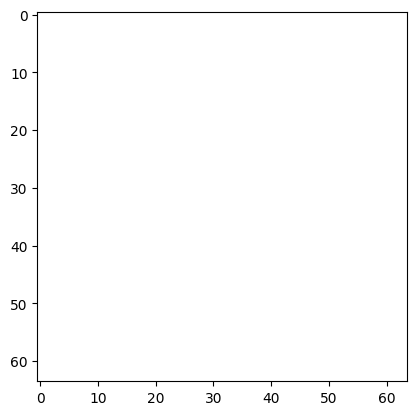

In [114]:
show_video(t_2[0])